# Computing a Loss Landscape for an RNN


This notebook demonstrates how you can use PyLossLandscapes to compute a loss landscape and save the resulting data to be analyzed later. We will use an RNN to classify names by their ethnic origin (from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

## Building and training the model

In [1]:
# first we have to download the dataset
import urllib.request
import subprocess
urllib.request.urlretrieve("https://download.pytorch.org/tutorial/data.zip", "data.zip")

('data.zip', <http.client.HTTPMessage at 0x7d56e0357d90>)

In [2]:
# unzip the archive
subprocess.run(["unzip", "data.zip"])

Archive:  data.zip


replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


CompletedProcess(args=['unzip', 'data.zip'], returncode=1)

In [3]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [4]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset, DataLoader

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [7]:
alldata = NamesDataset("data/names")
#dataloader = DataLoader(alldata, batch_size=64, shuffle=False, num_workers=1, generator=torch.Generator(device='cuda'))

In [8]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [10]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))

In [11]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

In [12]:
def get_params_grad(model):
    """
    get model parameters and corresponding gradients
    """
    params = []
    grads = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
        grads.append(torch.tensor(0.0) if param.grad is None else param.grad + 0.)
    return params, grads

In [13]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                text_tensor = lineToTensor(text)
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [ ]:
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)

In [15]:
# save the model
torch.save(rnn.state_dict(), 'model.pth')

In [14]:
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
rnn.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

## Computing the landscape

In [15]:
# subclass hessian to be consistent with our dataloader
from pyhessian.hessian import PyHessian
class RNNHessian(PyHessian):
    def __init__(self, model, criterion, data=None, dataloader=None, cuda=True):
        """
        model: the model that needs Hessain information
        criterion: the loss function
        data: a single batch of data, including inputs and its corresponding labels
        dataloader: the data loader including bunch of batches of data
        """
        super().__init__(model, criterion, data, dataloader, cuda)
        
        self.inputs, self.targets = self.data
        self.model.train()
        rnn.eval()
        rnn.rnn.train()
        with torch.backends.cudnn.flags(enabled=False):
            for i in zip(self.inputs, self.targets):
                d, t = i
                outputs = self.model(d)
                loss = self.criterion(outputs, t)
                loss.backward(create_graph=True)
        
        params, gradsH = get_params_grad(self.model)
        self.params = params
        self.gradsH = gradsH  # gradient used for Hessian computation

In [16]:
(label_tensor, data_tensor, data_label, data_item) = alldata[0:31]

In [17]:
# create a hessian calculator based on our model
hessian_comp = RNNHessian(rnn, nn.NLLLoss(), data = (data_tensor, label_tensor), cuda=True)

/home/frosty/Programs/Python/pylosslandscapes/.venv/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1273.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [18]:
lfn = nn.NLLLoss()
def loss_function(model, data):
    dt, lt = data
    batch_loss = 0
    for d in zip(dt, lt): 
        tt, lbl_t = d
        output = rnn.forward(tt)
        loss = lfn(output, lbl_t)
        batch_loss += loss
    return batch_loss

In [2]:
from landscaper.landscape import LossLandscape

In [20]:
rnn.eval()
rnn.rnn.train()

with torch.backends.cudnn.flags(enabled=False):
    landscape = LossLandscape.compute(
    rnn,
    (data_tensor, label_tensor),
    hessian_comp,
    loss_function, # loss function
    dim=2,
    device=device,
)

Top 10 eigenvalues: [-1945.0692138671875, 1785.5587158203125, -1789.1280517578125, -1531.213623046875, -1205.3426513671875, -1161.1180419921875, -1217.7020263671875, 1162.5096435546875, -1028.4920654296875, -1073.2711181640625]
Computing 1681 points in 2D space...


Computing 2D landscape: 100%|████████████████████████████████████████████████| 169/169 [00:22<00:00,  7.60it/s]

Loss hypercube stats - min: 1228.3504638671875, max: 1318.9652099609375, mean: 1274.527395889491


In [20]:
landscape.save("example.npz")

In [3]:
landscape  = LossLandscape.load_from_npz("example.npz")

Attempting log-scale surface plot...


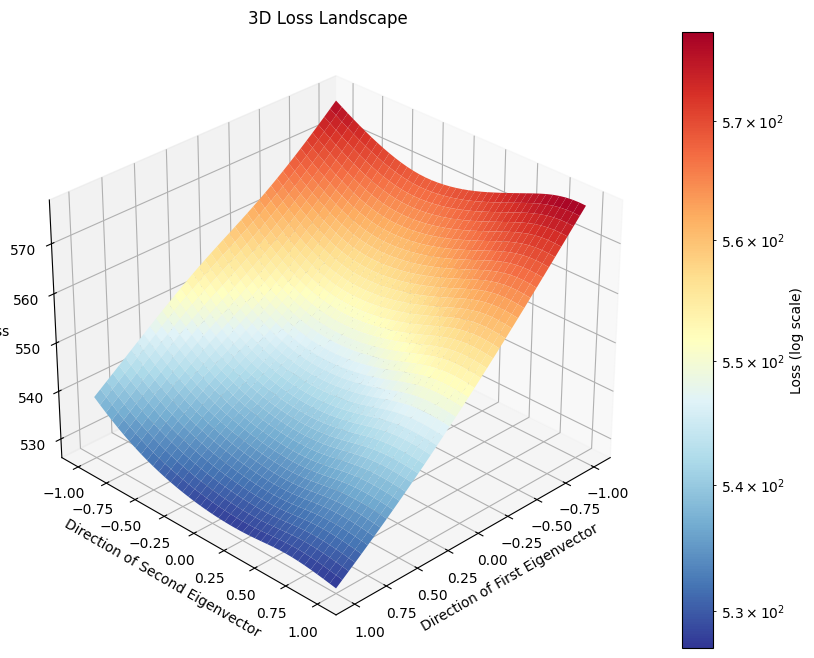

In [22]:
landscape.show()

X-axis range: 0.0, 1681.0
Y-axis range: 0.0, 577.5564575195312


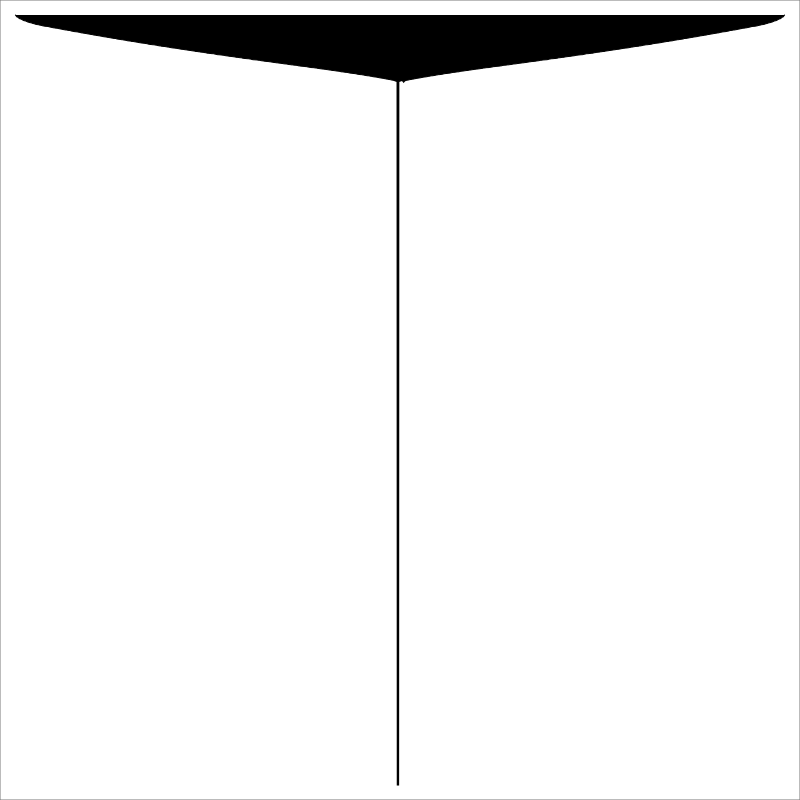

In [23]:
landscape.show_profile()

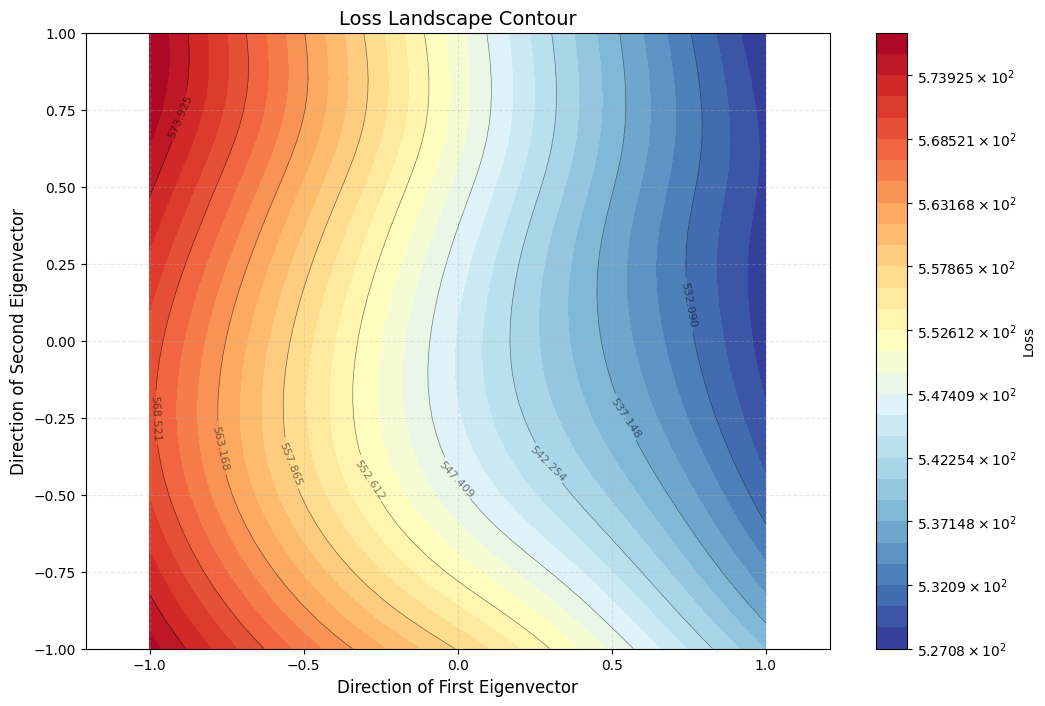

In [24]:
landscape.show_contour()

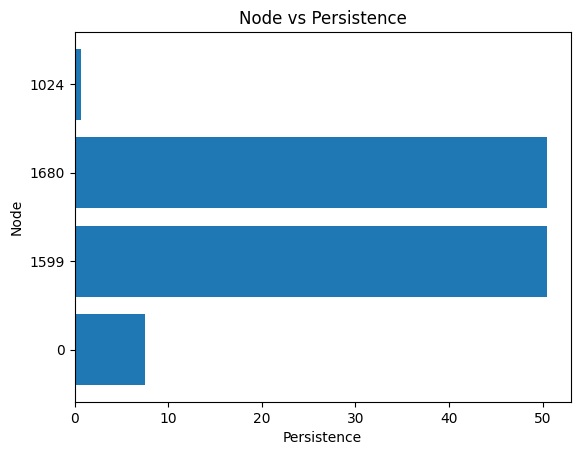

In [25]:
landscape.show_persistence_barcode()

In [5]:
# we can use this function to convert the merge tree 
# into a networkx graph and visualize it!
from landscaper.tda import merge_tree_to_nx
g = merge_tree_to_nx(landscape.get_sublevel_tree())

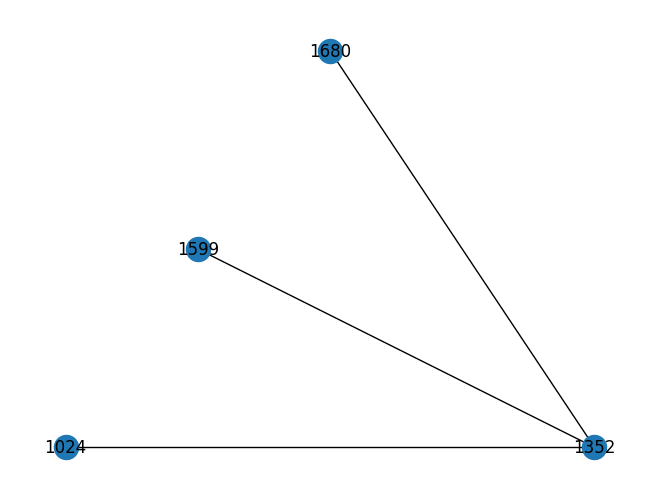

In [9]:
import networkx as nx
nx.draw_planar(g, with_labels=True)

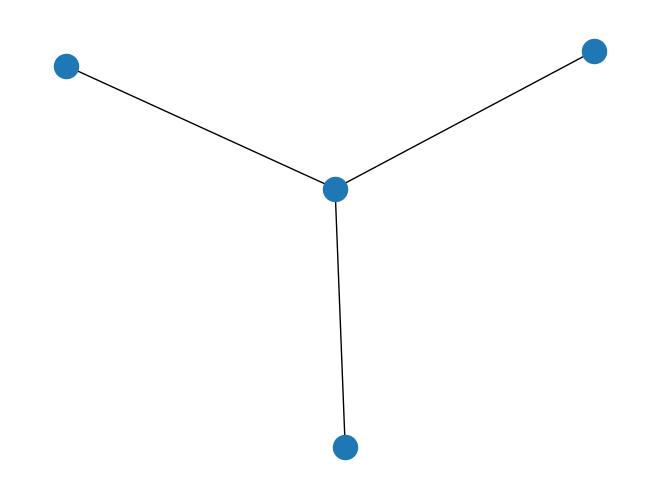

In [10]:
nx.draw(g)

In [3]:
landscape.smad()

0.97772216796875